<a href="https://colab.research.google.com/github/sebastianiu/Prognosemodell_Online_Kreditzahlungsverkehr/blob/main/models/test/Tuning_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Daten Laden

In [ ]:
# Bibliotheken laden
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dateien von Google Drive bereitstellen
from google.colab import drive
drive.mount('/content/drive')

# Excel auslesen
Datensatz = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Model Engineering/PSP_Jan_Feb_2019.xlsx',header = 0)
Datensatz = Datensatz.rename(columns = {"Unnamed: 0":"id"})

Mounted at /content/drive


# 2. Modellentwicklung & -bewertung
## Datenaufbereitung

In [ ]:
# Bilbiotheken laden
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  precision_score,roc_curve,auc,accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Datenaufbereitung
label_encoder_PSP = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_weekday = LabelEncoder()

ML_Daten = Datensatz.filter(['amount','success','PSP','country','card','tmsp','3D_secured'], axis=1)

ML_Daten['country'] = label_encoder_country.fit_transform(ML_Daten['country'])
ML_Daten['PSP'] = label_encoder_PSP.fit_transform(ML_Daten['PSP'])
ML_Daten['card'] = label_encoder_card.fit_transform(ML_Daten['card'])

# Datumswerte in Tag/ Wochentag/ Stunde aufteilen
ML_Daten['weekday'] = ML_Daten['tmsp'].dt.day_name()
ML_Daten['weekday'] = label_encoder_weekday.fit_transform(ML_Daten['weekday'])
ML_Daten['day'] = ML_Daten['tmsp'].dt.strftime('%d').astype(int)
ML_Daten['hour'] = ML_Daten['tmsp'].dt.strftime('%H').astype(int)

# Separation in X Merkmale and Zielvariable Y
Y = ML_Daten['success']
X = ML_Daten.filter(['amount','PSP','3D_secured','card','country','weekday','day','hour'], axis=1)

#Features Daten skalieren
'''
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
'''
'''
# instance of the StandardScaler
sc = StandardScaler()
# fit the scaler to the data
sc.fit(X)
# transform the data using the scaler
data_scaled = sc.transform(X)
'''
# Aufteilung in Trainings- und Validierungsdatensatz
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Funktion zur Modellbewertung

In [ ]:
def Visualisierung_AUC(model,x_test,y_test):
  # Berechnung der Falsch-Positiv-Rate und der Wahr-Positiv-Rate für alle Schwellenwerte der Klassifizierung
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  # Visualisierung
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def Visualisierung_Class_Errors(model,x_test,y_test):
  #Vorhersage
  y_pred = model.predict(x_test)
  #Zippe Daten in Liste
  list(zip(y_pred,y_test))
  #Entzippe Liste
  unzip_file = [{'y_pred':y_pred,'y_test':y_test}for y_pred,y_test in zip(y_pred,y_test)]
  #Estelle DataFrame
  data = pd.DataFrame(unzip_file)
  #Ermittel Classification Error
  data['class_error'] = abs(data.y_pred-data.y_test)
  data = pd.concat([data,x_test], axis=1, join="inner")
  data['zaehler'] = 1

  # Decode Features
  data['PSP'] = label_encoder_PSP.inverse_transform(data['PSP'])
  data['country'] = label_encoder_country.inverse_transform(data['country'])
  data['card'] = label_encoder_card.inverse_transform(data['card'])
  data['weekday'] = label_encoder_weekday.inverse_transform(data['weekday'])

  max = data.amount.max()

  def create_amount_quantiles(row):
    if row['amount'] > 0 and row['amount'] <= max/4:
      result = '0 - '+str(max/4)
    else:
      if row['amount'] > max/4 and row['amount'] <= max/4*2:
        result = str(max/4+1)+' - '+str(max/4*2)
      else:
        if row['amount'] > max/4*2 and row['amount'] <= max/4*3:
          result = str(max/4*2+1)+' - '+str(max/4*3)
        else:
          result = str(max/4*3+1)+' - '+str(max)
    return result

  data['amount_quantiles'] = data.apply(create_amount_quantiles, axis=1)


  field_list = ['PSP','card','country','weekday','3D_secured','amount_quantiles']
  error_rates = pd.DataFrame(columns=['Merkmal','Merkmalswert','class_error','zaehler'])

  for field in field_list:
    errors = data.groupby(data[field])['class_error'].sum()
    total = data.groupby(data[field])['zaehler'].sum()
    error_rates_tmp = pd.concat([errors, total], axis=1)
    error_rates_tmp['Merkmalswert'] = error_rates_tmp.index.values
    error_rates_tmp['Merkmal']=field
    error_rates_tmp.reset_index()
    error_rates = pd.concat([error_rates,error_rates_tmp])

  error_rates['class_error_rate'] = error_rates.zaehler/error_rates.class_error
  max_error_rate = error_rates['class_error_rate'].max()

  # Visualisiere Verteilungen
  fig = px.bar(error_rates, x='Merkmalswert', y='class_error_rate', color= 'Merkmal',labels={'class_error_rate':'Klassifizierungsfehler in %'},title="Fehlerrate Klassifizierungen")
  fig.add_hline(y=max_error_rate,line_dash="dot",annotation_text=str(round(max_error_rate,2))+' %',annotation_position="top left")
  fig.show()

def Model_Bewertung(model,x_train, y_train,x_test, y_test,X,Y):
  y_pred_proba = model.predict_proba(x_test)
  cross_validation_tmp = cross_val_score(model, X, Y, cv=6)
  cross_validation=[]
  for value in cross_validation_tmp:
    new = round(value,3)
    cross_validation.append(new)


  print('Bewertungsmetriken')
  print('#'*20)
  print(f"Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(model.score(x_train, y_train),2)}")
  print(f"Vorhersage-Genauigkeit auf Basis der Testdaten: {round(model.score(x_test, y_test),2)}")
  print('*'*15)
  precision_train = round(precision_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  precision_test = round(precision_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"Precision auf Basis der Trainingsdaten: {precision_train}")
  print(f"Precision auf Basis der Testdaten: {precision_test}")
  print('*'*15)
  f1_score_train = round(f1_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  f1_score_test = round(f1_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"F1-Score auf Basis der Trainingsdaten: {f1_score_train}")
  print(f"F1-Score auf Basis der Testdaten: {f1_score_test}")
  print('*'*15)
  print(f"Vorhersage-Genauigkeiten nach Kreuz-Validierung: {cross_validation}")
  print(f"Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: {round(sum(cross_validation)/len(cross_validation),3)}")

  print('*'*15)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.8
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.71
F1-Score auf Basis der Testdaten: 0.71
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.797, 0.797, 0.797, 0.797, 0.797, 0.797]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.797
***************


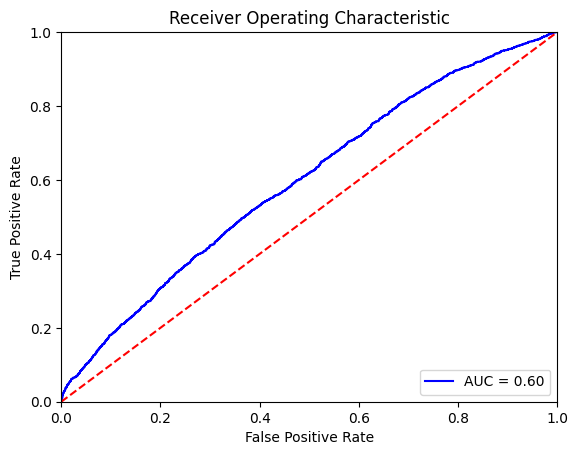

TypeError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

Model_Bewertung(lg,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(lg,x_test,y_test)
Visualisierung_Class_Errors(lg,x_test,y_test)

## 2.2 Logistische Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.8
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.71
F1-Score auf Basis der Testdaten: 0.71
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.797, 0.797, 0.797, 0.797, 0.797, 0.797]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.797
***************


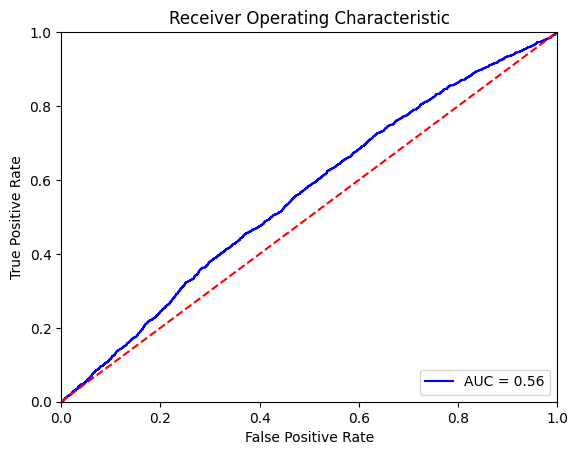

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

Model_Bewertung(lg,x_train, y_train,x_test, y_test,X,Y)
Visualisierung_AUC(lg,x_test,y_test)
Visualisierung_Class_Errors(lg,x_test,y_test)

# 3 Logistik Regression feintunen

In [ ]:
# 1) Merkmale reduzieren anhand Erkenntissen aus EDA und Separation in X Merkmale and Zielvariable Y
X2 = ML_Daten.filter(['amount','PSP','3D_secured'], axis=1)
# Neue Aufteilung in Trainings- und Validierungsdatensatz
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=0.2)

# Modell trainieren
LR_final = LogisticRegression(max_iter=10)
LR_final.fit(x_train2,y_train2)
#Bewertung
Model_Bewertung(LR_final,x_train2, y_train2,x_test2, y_test2,X,Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.79
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.81
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.7
F1-Score auf Basis der Testdaten: 0.72
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.797, 0.797, 0.797, 0.797, 0.797, 0.797]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.797
***************


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## 3.1 Hyperparameter-Tuning mittels Kreuz-Validierung
### Hyperparameter-Raster

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold

# Hyper-Parameter für Raster
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

### Umfassende Rastersuche

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=LR_final, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train2,y_train2)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Bewertung der ermittelten optimalen HP
#print('Model-Bewertung mit Hyper-Parametern ermittelt mit GridSearchCV')
#print(f'Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {grid_result.score(x_train2,y_train2):.3f}')
#print(f'Vorhersage-Genauigkeit auf Basis der Testdaten: {grid_result.score(x_test2,y_test2):.3f}')

Best: 0.794386 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794386 (0.000096) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794386 (0.000096) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794386 (0.000096) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794386 (0.000096) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794386 (0.000096) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794386 (0.000096) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.794386 (0.000096) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794386 (0.000096) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794386 (0.000096) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.794386 (0.000096) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794386 (0.000096) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794386 (0.000096) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.794386 (0.000096) wit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



In [ ]:
#Bewertung der ermittelten optimalen HP
print('Model-Bewertung mit Hyper-Parametern ermittelt mit GridSearchCV')
print(f'Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {grid_result.score(x_train2,y_train2):.3f}')
print(f'Vorhersage-Genauigkeit auf Basis der Testdaten: {grid_result.score(x_test2,y_test2):.3f}')

Model-Bewertung mit Hyper-Parametern ermittelt mit GridSearchCV
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.794
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.808


### Zufalls-basierte Parameter-Optimierung

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
GridsearchRandom = RandomizedSearchCV(estimator = LR_final, param_distributions = grid,cv = cv, verbose=2, random_state=42, n_jobs = -1)
GridsearchRandom.fit(x_train2,y_train2)

print('Optimale H-Parameter')
print('+'*20)
print(GridsearchRandom.best_params_)

#Bewertung der ermittelten optimalen HP
print('Model-Bewertung mit Hyper-Parametern ermittelt mit RandomizedSearchCV')
print(f'Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {GridsearchRandom.score(x_train2,y_train2):.3f}')
print(f'Vorhersage-Genauigkeit auf Basis der Testdaten: {GridsearchRandom.score(x_test2,y_test2):.3f}')

# GGf. Regularisierung bei Overfit integrieren

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Optimale H-Parameter
++++++++++++++++++++
{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
Model-Bewertung mit Hyper-Parametern ermittelt mit RandomizedSearchCV
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.794
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.808


/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



In [ ]:
# Modell finale mit allen Daten trainieren

LR_final.fit(X2,Y)

#Finale Bewertung
Model_Bewertung(LR_final,x_train2, y_train2,x_test2, y_test2,X2,Y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.79
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.81
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.7
F1-Score auf Basis der Testdaten: 0.72
***************
Vorhersage-Genauigkeiten nach Kreuz-Validierung: [0.797, 0.797, 0.797, 0.797, 0.797, 0.797]
Durschn. Vorhersage-Genauigkeit nach Kreuz-Validierung: 0.797
***************
